# Why did the Vasa ship sink?

### 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import g
from IPython.display import Image
Image(url= "https://i.imgur.com/Rb3B7r9.png", width=400, height=400)

This is a Schematic drawing of our ship model.

The Vasa ship was a swedish man of war that sank on the ship's maiden voyage in august 1628, the biggest contributing factors for the shipwreck was the fact that Vasa had very little initial stability combined with the fact that its righting moment was too small to bring it to an upright position. On the maiden voyage the lower cannondeck had its hatches open to fire a salute and when the wind made the ship careen, water started flowing inside and eventually capsized the ship.

Using numerical solutions of ODEs and physical models with some assumptions we will take a deeper look at how and why the ship sank. We model the ship’s hull as a half cylinder with a radius of $10$ metres. We will first look at how the boat with given parameters will behave when the amount of water displaced is constant. This is a big assumption and will not provide interesting physical results in itself, however it will help us demonstrate how different ODE solvers have varying degrees of precision of accuracy depending on their order, and the given step length. 

The sector angle which spans out the water horizon from the metacenter is given by $\beta$ in equilibrium. The area of the displaced water in equilibrium is given by $A_0 = \frac{1}{2} R^2(\beta-\sin{\beta})$ with $\sigma$ and $\sigma_0$ being the boat and the water density respectively, we are left with the following equation:

$$\beta-\sin{\beta} = \frac{\pi \sigma}{\sigma_0}$$

This equation is solvable numerically with the  fixed-point iteration method, which we will demonstrate below:

In [ ]:
def fixedpoint(g, start_angle, tol=1.e-8, max_iter=200):
    """
    g: Fixpoint function.
    start_angle: What angle to start iterating from.
    tol: Lowest error tolerance.
    max_iter: Maximum number of iterations if the solver does not converge.

    Solves the fixed-point equation with the fixed-point iteration method. 

    Return: The root of the equation, in this case the sector angle of the water from the metacenter.
    """
    angle = start_angle
    for k in range(max_iter):
        angle_old = angle
        angle = g(angle)
        err = abs(angle-angle_old)
        if err < tol:
            break
    return angle

In [ ]:
def groot(angle):
    """
    angle: Input of equation.

    This is the equation used to solve the fixed-point iteration.
    
    Return: Solution to the helping equation.
    """
    return np.sin(angle) + np.pi * total_density / water_density

In [ ]:
#Global constants
boat_density = 500
water_density = 1000
total_density = boat_density # We start off by only looking at the boats mass
sector_angle_0 = fixedpoint(groot,0)
radius = 10
h = 4 * radius / (3 * np.pi) # The distance between the metacenter and the center of mass
g = 9.81 # Acceleration of gravity on planet earth
shipmass = np.pi*radius**2/2*boat_density
inertia = 1/2*shipmass*radius**2*(1-32/(9*np.pi**2))

theta_symbol = "\u03B8"
degree_sign = "\u00B0"

When choosing our fixedpoint equation there are two choices for $g(\beta)$:
$$ g_1(\beta) = \sin{\beta} + \frac{\pi \sigma}{\sigma_0}$$
$$ g_2(\beta) = \arcsin{\left(\beta - \frac{\pi \sigma}{\sigma_0} \right)}$$
Using $g_2(\beta)$ doesn't make sense here because it's domain is $[-1,1]$ and we can not guarantee that  $\left|\beta - \pi \cdot \frac{500}{1000}\right|  < 1$. We therefore use the $g_1(\beta)$ to calculate the sector angle $\beta$ at equilibrium.

There are exists other methods we can use to solve the fixed-point equation, but the fixed-point iteration method is the best suited for our case. The bisection method requires you to specify an interval to iterate on, which we chose to avoid here. Newtons method usually converges quickly, but has a fatal flaw in this case. For newtons method to always converge there has to exist a $M$ such that $\left|\frac{f''(x)}{f'(x)}\right| < 2M$. Because $\left|\frac{f''(\beta)}{f'(\beta)}\right|$ might diverge, there can exist no such $M$ and there is a possibility that we don't get a respectable answer from the method. A convergence criteria for the fixed-point iteration method is that $|g'(\beta)|$ is never higher than $1$. $|g_1'(\beta)|$ will never produce an answer higher than $1$ which means the method will always converge. Because of the convergence of the method and known behaviour of the sine-function we can arbitrarily choose the starting iteration value, so we will just stick with $0$.

In [ ]:
np.rad2deg(fixedpoint(groot,3*np.pi/4, max_iter=1000, tol=1e-10))

132.3464588319283

With the given parameters for the Vasa ship the sector angle $\beta$ at equilibrium is $132.3$ degrees

To model the ship we are going to introduce a vector $\vec{w}(t)$ that contains all the variables that changes with the ships rocking motion. To begin with we define the vector as such:

$$\vec{w} = \begin{bmatrix} \theta (t) \\ \omega (t) \end{bmatrix}$$

Here $\theta(t)$ is the angle of rotation on the ship as a function of time, and $\omega (t)=\frac{d\theta}{dt}$.

To model this as a differential equation we now define $\vec{f} (t,\vec{w}) = \frac{d\vec{w}}{dt}$. This means we have:

$$\frac{d\vec{w}}{dt} = \begin{bmatrix} \dot{\theta} (t) \\ \dot{\omega} (t) \end{bmatrix} = \begin{bmatrix} \omega (t) \\ \ddot{\theta} (t) \end{bmatrix}$$

The angular velocity $\omega (t)$ will just return itself from the function while $\ddot{\theta}$ can be calculated from the following equation:

$$ I_c \ddot{\theta} = \sum \tau $$

With $I_c$ being the inertia of the ship and $\tau$ is the effective torques.

For now we will only look at one contribution to the torque, namely the buoyancy $\tau_B = -F_B h \sin{\theta}$ where the buoyant force is $F_B = A \sigma_0 g$ with $A$ being the area of the displaced water. With no motion in the $y$-direction $F_B$ will also equal $mg$ following Archimedes principle, which we will use later. This also means we can set $A=A_0$. The gravitational force will not have an effect on the torque since its point of attack is at the center of mass.

In [ ]:
gravcenter_w_0 = lambda angle : radius*(4*np.sin(angle/2)**3)/(3*(angle-np.sin(angle))) # Y_MB
metacenter_0 = lambda angle : radius*np.cos(angle/2) # y_m
centermass_0 = lambda angle : metacenter_0(angle) - h # y_c
buoyancy_point_0 = lambda angle : metacenter_0(angle) - gravcenter_w_0(angle) # y_b
deep_point_0 = lambda angle : metacenter_0(angle) - radius # y_d

water_area_0 = lambda angle = sector_angle_0 : 1/2 * radius ** 2 * (angle - np.sin(angle)) # Area of displaced water in equilibrium
buoyancy = lambda area : area*water_density*g # The buoyant force on the ship

We have now defined a range of constants, some as global variables, and some as functions. Among these we have $h$ which is the distance between the metacenter and the center of mass. The other constants implemented, where $\gamma$ is the general sector angle which we define later, is:

$$ Y_{MB} = R\frac{4\sin^3{\frac{\gamma}{2}}}{3(\gamma-\sin{\gamma})}$$

$$ y_M^0 = R\cos{\frac{\beta}{2}}$$

$$ y_C^0 = y_M^0 - h$$

$$ y_B^0 = - Y_{MB}$$

$$ y_D^0 = y_M^0 - R$$

$Y_{MB}$ is the distance from the gravitanional center of the displaced water and the metacenter, $y_M^0$ is the metacenter of the ship, $y_C^0$ is the center of mass of the ship, $y_B^0$ is the attack point of the buoyant force and $y_D^0$ is the deepest point on the ship. We have here defined $y=0$ to be the water horizon.

## Euler method
We're now going to solve the IVP numerically. To begin with the method we are going to use is the Euler method. This is a first order numerical procedure to solve differential equations and is not the most sophisticated method, especially when the step size is large, which we will now explore.

In [ ]:
def euler(f, t, w, step):
    """
    f: Input function.
    t: Function variable.
    w: Function dependent on t.
    step: Size of the step of one iteration.

    One iteration of the numerical Euler method.

    Return: The variable and function after one step.
    """
    w_next = w + step*f(t, w)
    t_next = t + step
    return t_next, w_next

In [ ]:
def ode_solver(f, t_0, t_end, w_0, step, method=euler):
    """
    f: Input function.
    t_0: The starting point of the dependant variable.
    t_end: The end point of the dependant variable.
    w_0: Initial conditions of the function.
    step: Size of the step of one iteration.
    method: What iteration method is to be used.

    The function that numerically solves the differential equation.

    Return: Arrays with the w-vector- and t-values
    """

    w_num = np.array([w_0])
    t_num = np.array([t_0])

    t_next = t_0
    w_next = w_0

    
    while t_next < t_end:
            t_next, w_next = method(f, t_next, w_next, step) # Using the numerical method
            w_num = np.concatenate((w_num, np.array([w_next]))) # Adding the new values to the solution
            t_num = np.concatenate((t_num, np.array([t_next])))
    
    t_next, w_next = method(f, t_next, w_next, t_end-t_next)
    w_num = np.concatenate((w_num, np.array([w_next])))
    t_num = np.concatenate((t_num, np.array([t_next])))    
    if(w_0.shape[0] > 2): # This ensures that we only include the posibility of capsizing for RK4 and the method chosen in 2h
        capsized(w_num) # Checks if the ship capsized
    return t_num, w_num

In [ ]:
def capsized(w):
    """
    w: The w-vector.

    Function that checks if the ship has capsized.

    Return: A correct w-vector with information depending on whether the ship capsized or not.
    """
    for i in range(w.shape[0]):
        if (np.abs(w.T[0,i]) >= (np.pi-sector_angle(w[i]))/2): # The capsizing condition
            w.T[1:,i:] = 0 # All values (except the angle) after the ship has capsized become 0
            w.T[0,i:] = np.sign(w.T[0,i-1])*0.5*np.pi # The angle will either be pi/2 or -pi/2
            break
    return w

In [ ]:

harmonic = lambda t, w: np.array([w[1],-buoyancy(water_area_0())*h/inertia*np.sin(w[0])])
x_harmonic, y_harmonic = ode_solver(harmonic,0,20,np.array([np.pi/9,0]),0.1)
x_harmonic_2, y_harmonic_2 = ode_solver(harmonic,0,20,np.array([np.pi/9,0]),0.01)
x_harmonic_3, y_harmonic_3 = ode_solver(harmonic,0,20,np.array([np.pi/9,0]),0.001)
x_harmonic_4, y_harmonic_4 = ode_solver(harmonic,0,20,np.array([np.pi/9,0]),0.0001)

We have now solved the differential equation with the buoyancy thrifting the torque, with the initial values $\theta(t=0) = 20\mathring{}$, $\omega (t=0)=0$. We solve for $t \in [0,20]$ and varying step sizes, which are discussed later.

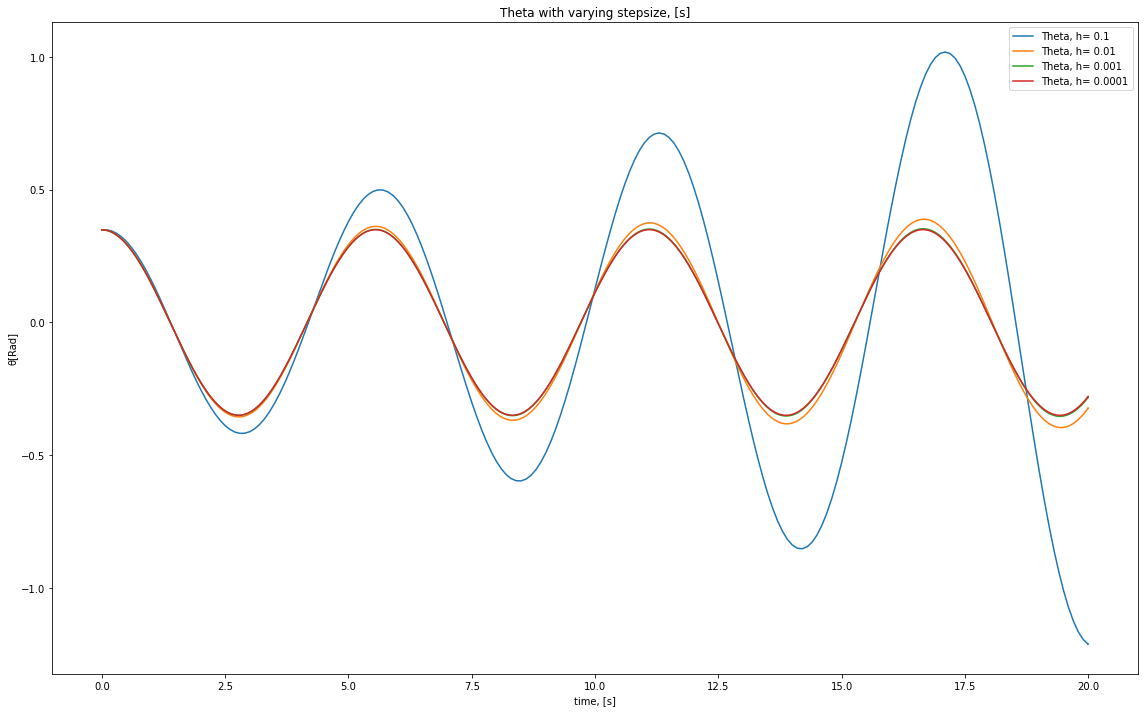

In [ ]:

plt.rcParams["figure.figsize"] = (16,10)
fig, axs = plt.subplots(1,1)
axs.plot(x_harmonic,y_harmonic.T[0],label = "Theta, h= 0.1")
axs.set_title("Theta with varying stepsize, [s]")
axs.set_xlabel("time, [s]")
axs.set_ylabel(f"{theta_symbol}[Rad]")



axs.plot(x_harmonic_2,y_harmonic_2.T[0],label = "Theta, h= 0.01")

axs.plot(x_harmonic_3,y_harmonic_3.T[0],label = "Theta, h= 0.001")

axs.plot(x_harmonic_4,y_harmonic_4.T[0],label = "Theta, h= 0.0001")
axs.legend()

plt.tight_layout()
plt.show()


From the plots above we can see that the accuracy drasticly improves when the step size decreases. This is because the distance of each point we calculate decreases which again makes the error smaller. This increases the runtime because the number of calculations increases. Solving differential equations numerically is a constant battle between runtime and accuracy.
Using step length $h = 0.1$ gives a solution where the amplitude of the angle $\theta$ keeps increasing. In order to achieve this the mechanical energy of the system would have to be constantly increasing, we know that this is not the case, and can therefore conclude that $h = 0.1$ is a bad choice of step length. With a step length of $h = 0.01$ the amplitude increases ever so slightly over the $20$ second time interval and we have to use a step size of at most $h = 0.001$ for results that are consistent over the interval. 
This is fine for equations with simple calculations and small intervals to compute over, but if we were to increase the length of the interval the runtime would skyrocket, we will later see how Runge-Kutta 4 is noticeably better even over a small interval like $[0,20]$


In [ ]:
harmonic_simple = lambda t, w : np.array([w[1],-buoyancy(water_area_0())*h/inertia*w[0]])
t_harmonic_s, w_harmonic_s = ode_solver(harmonic_simple,0,20,np.array([np.radians(20),0]),0.001)
t_harmonic_s2, w_harmonic_s2 = ode_solver(harmonic_simple,0,20,np.array([np.radians(1),0]),0.001)
t_harmonic_5, w_harmonic_5 = ode_solver(harmonic,0,20,np.array([np.radians(1),0]),0.001)

For small angles the approximation $\sin{\theta} = \theta$ is common and quite accurate for angles up to $10\mathring{}$. This makes our initial equation way simpler and it is actually possible to solve it analytically, which we will do further down the road. Our time interval will still be $t \in [0,20]$ but our initial conditions will firstly be $\theta (t=0) = 20\mathring{}$ and then $\theta (t=0) = 1\mathring{}$. We have $\omega (t=0) = 0$ for all solutions and we keep our step size of $h=0.001$.

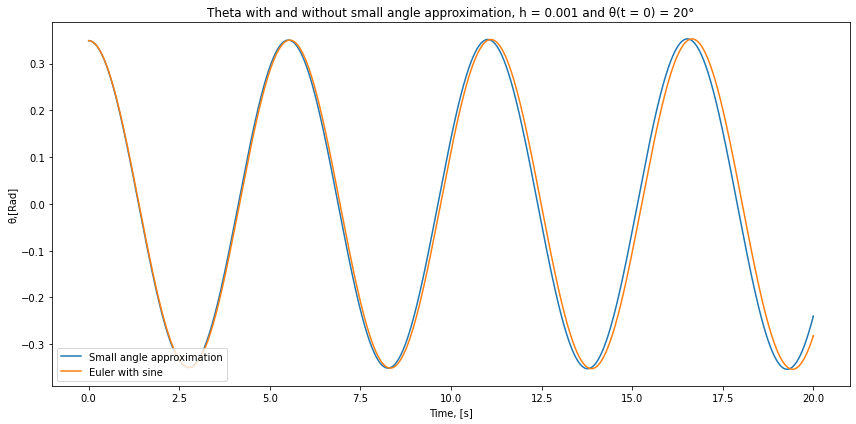

In [ ]:

plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1, 1)

axs.plot(t_harmonic_s,w_harmonic_s.T[0], label = "Small angle approximation")

axs.plot(x_harmonic_3,y_harmonic_3.T[0], label = "Euler with sine")
axs.legend(loc = 3)
axs.set_title(f'Theta with and without small angle approximation, h = 0.001 and {theta_symbol}(t = 0) = 20{degree_sign}')
axs.set_xlabel("Time, [s]")
axs.set_ylabel(f"{theta_symbol},[Rad]")
plt.tight_layout()
plt.show()

The small angle approximation is, like we would expect, a bad approximation for large angles which is clearly shown in the plot above. After just $2.5$ seconds we can clearly see the two graphs are no longer overlapping, this is because the small angle approximation introduces an error that grows at every extremum. 

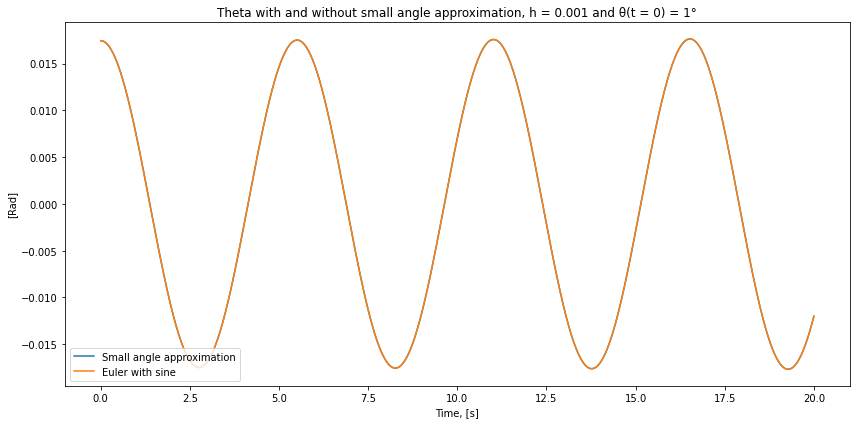

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1, 1)

axs.plot(t_harmonic_s2,w_harmonic_s2.T[0], label = "Small angle approximation")
axs.plot(t_harmonic_5,w_harmonic_5.T[0], label = "Euler with sine")
axs.legend(loc = 3)
axs.set_title(f'Theta with and without small angle approximation, h = 0.001 and {theta_symbol}(t = 0) = 1{degree_sign}')
axs.set_xlabel("Time, [s]")
axs.set_ylabel("[Rad]")
plt.tight_layout()
plt.show()

With start angle $\theta (t=0) = 1\degree$ the approximation is very good and it is not possible from the plot to distinguish the two graphs from eachother. The small angle approximation is therefore a strong tool for physicists when dealing with difficult equations involving oscillations. However, as we discussed above, the error in the approximation is rapidly increasing for larger values of $\theta$

## Runge-Kutta 4th order

For a better numerical solution to the initial value problem, a higher order iteration method needs to be implemented. The Runge-Kutta methods generalizes the Euler method and can be implemented with a higher order than 1. In this solution we are going to be using the 4th order Runge-Kutta numerical method.

In [ ]:
def runge_kutta_4(f,t,w,step):
    """
    f: Input function.
    t: Function variable.
    w: Function dependent on t.
    step: Size of the step of one iteration.

    One iteration of the numerical Runge-Kutta 4 method.

    Return: The next t value and w-values.
    """
    k1 = f(t,w)
    k2 = f(t+step/2,w+step*k1/2)
    k3 = f(t+step/2,w+step*k2/2)
    k4 = f(t+step,w+step*k3)
    w_next = w + step*(k1 + 2*k2 + 2*k3 + k4) / 6
    t_next = t + step
    return t_next, w_next

We find the analytic solution of the equation $-mgh\theta(t)=I_c\ddot{\theta}(t)$ using the small angle approximation which gives us the solution:

$$\theta (t) = \theta_0 \cos{\left(\frac{F_B\cdot h}{I_c}t\right)}$$

In [ ]:
def analytic_small_angle_approx(theta_s,t):
    """
    theta_s: Starting angle
    t: Function variable

    Analytic solution to the equation with small angle approximation.

    Return: The solution to the equation.
    """
    k = np.sqrt(buoyancy(water_area_0())*h/inertia)
    A = theta_s
    return A*np.cos(k*t)

h_vals = np.linspace(0.001,0.1,1500)

def h_error_finder(method,ODE = harmonic_simple):

    """
    method: Takes in the method for solving the ODE

    Uses the ode_solver with the given method to solve the given ODE
    Takes the absolute value of the difference between the numerical and the analytic solution and 
    concatenates it to an array. does this for 1500 different step lenghts between 0.001 and 0.1

    Return: An array of all the differences between numerical and analytic solution
    """
    error_list = np.array([])

    for i in range(1500):
        t_val, w_vec = ode_solver(ODE,0,20,np.array([0.01,0]),h_vals[i],method)
        error = np.abs(analytic_small_angle_approx(0.01,20)-w_vec.T[0][-1])
        error_list = np.concatenate((error_list,np.array([error])))    

    return error_list

In [ ]:
rk_error = h_error_finder(runge_kutta_4)
euler_error = h_error_finder(euler)


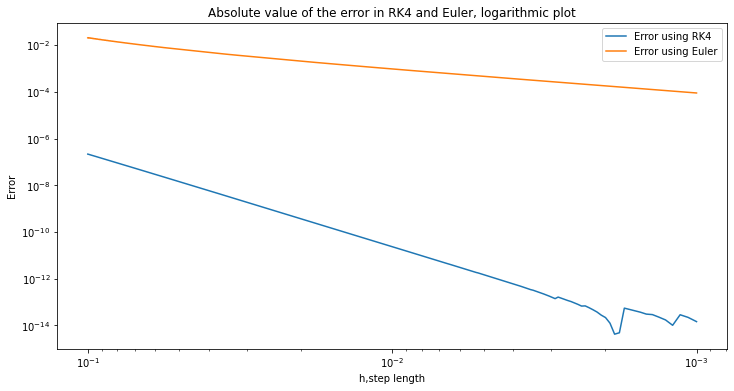

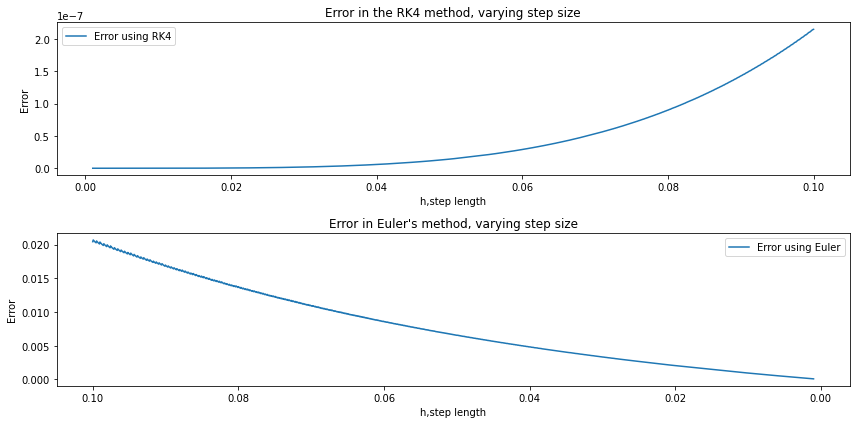

Slope of the error using the Euler method: 1.2448480301947051
Slope of the error graph for the Euler method using the 250 shortest step lengths: 1.049367738437122
Slope of the first half of the error in the solution using the Euler method: 1.656424694639781
Slope of the error for the last 500 step lenghts using RK4 method: 3.946843307584587


In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
fig,axs = plt.subplots(1,1)

axs.loglog(h_vals,rk_error,label = "Error using RK4")
axs.loglog(h_vals,euler_error, label = "Error using Euler")
axs.set_title("Absolute value of the error in RK4 and Euler, logarithmic plot")
axs.set_xlabel("h,step length")
axs.set_ylabel("Error")
axs.invert_xaxis()
axs.legend()
plt.show()

plt.rcParams["figure.figsize"] = (12,6)
fig,axs = plt.subplots(2,1)

axs[0].plot(h_vals,rk_error,label = "Error using RK4")
axs[0].set_title("Error in the RK4 method, varying step size")
axs[0].set_xlabel("h,step length")
axs[0].set_ylabel("Error")
axs[0].legend()
axs[1].plot(h_vals,euler_error, label = "Error using Euler")
axs[1].set_title("Error in Euler's method, varying step size")
axs[1].set_xlabel("h,step length")
axs[1].set_ylabel("Error")
axs[1].invert_xaxis()
axs[1].legend()
plt.tight_layout()
plt.show()

def func(x,a,b):
    return a*x+b
euler_fit, pcov = curve_fit(func,np.log(h_vals),np.log(euler_error))
euler_fit2, pcov = curve_fit(func,np.log(h_vals[:250]),np.log(euler_error[:250]))
euler_fit3, pcov = curve_fit(func,np.log(h_vals[750:]),np.log(euler_error[750:]))

rk_fit, pcov = curve_fit(func,np.log(h_vals),np.log(rk_error))

print(f'Slope of the error using the Euler method: {euler_fit[0]}')
print(f'Slope of the error graph for the Euler method using the 250 shortest step lengths: {euler_fit2[0]}')
print(f'Slope of the first half of the error in the solution using the Euler method: {euler_fit3[0]}')

print(f'Slope of the error for the last 500 step lenghts using RK4 method: {rk_fit[0]}')

In the above plots the error between the numerical and the analytic solution is plotted on a logarithmic scale, this lets us easily verify the order of our method by looking at the slope of each line. The x-axis is inverted to easier show how a decrease in step size corresponds to a decrease in error. Since the x-axis is inverted the order of each method is the absolute value of the slope. Furthermore, as the step size increases, the error increases and therefore the most accurate interval to calculate the slope and order of each method is for the first few hundred step sizes. This is illustrated below the plot where the slope for the $250$ shortest step sizes for Eulers method is printed.

The order of RK4, and therefore the slope of the logarithmic error plot, should be $4$. Except for some anomalies caused by floating point error, which is demonstrated below, the plot of the error in the RK4 method on a logarithmic scale is nice and linear. 
Comparing the overall value of the error between Euler and RK4 methods we see how much better RK4 is at every step size. 


In [ ]:
print(1/2-1/6-2/6)

5.551115123125783e-17


In the above example we see how the computer adds an error when dealing with small floating points, considering that the value should be $0$. Values at an order of magnitude lower than $10^{-16}$ are prone to floating point error. When RK4 uses a very short step size, the error is very small, and theerefore there is a possibility of floating point error. The error is only calculated after the last iteration and therefore the lowest error is only at an order of magnitude $10^{-14}$, this is caused by the fact that the earlier iterations that should have added no error actually adds some error because of floating point error. Combined this brings the error above an order of magnitude $10^{-16}$. This is also illustrated by the fact that the jagged part of the error on a logarithmic scale corresponds to the step sizes where the error is flat and close to zero. 

Finally we conclude that RK4 is a much stronger method for solveing ODEs than Euler's method considering that the overall error is smaller for every step size. Which is why we will use RK4 or other higher order solvers for the remainder of this project.

# Ship dynamics with moving centre of mass.

We have now found an ODE solver that is highly accurate, and therefore we move on to a more complicated system. The amount of water displaced will now change as a function of the angle $\theta$. We will look at the movement of the centre of mass and also how the boat behaves when you add, cargo,fences so the cargo can not slide off ,friction from the water and additionally, we will add the possibility of the boat capsizing.  

To achieve this we have to generalise how we calculate the area of displaced water, the sector angle, and expand the size of $\vec w$ so it contains the necessary information for simulating the above mentioned scenarios. 

The sector angle is given by:

$$ \gamma = 2\cos^{-1}\left({\cos{\frac{\beta}{2}} - \frac{4}{3 \pi}(1 - \cos{\theta})+\frac{\Delta y_c}{R} }\right) $$

The area of displaced water is then given by:

$$ A = \frac{1}{2} R^2(\gamma-\sin{\gamma})$$

We now expand $\vec{w}$ to include the $x$ and $y$ position of the center of mass as well as their respective velocities. We write the vector as such:

$$\vec{w} = \begin{bmatrix} \theta \\ \omega \\ x_C \\ y_C \\ v_x \\ v_y \end{bmatrix}$$

This gives us a new $\vec{f} (t,\vec{w})$:

$$\vec{f} (t,\vec{w}) = \frac{d\vec{w}}{dt} = \begin{bmatrix} \dot{\theta} \\ \dot{\omega} \\ v_x \\ v_y \\ a_x \\ a_y \end{bmatrix}$$

Here $\omega $ will be returned the same way as earlier, the same goes for $v_x$ and $v_y$, but there are no forces working in the $x$-direction so we set both $v_x$ and $a_x$ to zero for the time being.

We can find $\dot{\omega}$ same as before by calculating the torque which in this case will be the same as before, and similarly we find $a_y$ by calculating the forces in $y$-direction:

$$ \ddot{\theta} = \frac{1}{I_C} \sum \tau$$

$$ a_y = \frac{1}{m} \sum F_y$$

$$ \sum \tau = \tau_B = -F_Bh\sin{\theta}$$

$$ \sum F_y = F_G + F_B = -mg + A\sigma_0 g$$

We will now study the movement of the center of mass in $y$-direction.

In [ ]:
sector_angle = lambda w : 2 * np.arccos(np.cos(sector_angle_0/2)-(4/(3 * np.pi))*(1-np.cos(w[0]))+(w[3]-centermass_0(sector_angle_0))/radius)
water_area = lambda w : 0.5*(radius**2)*(sector_angle(w)-np.sin(sector_angle(w)))

def ship(t,w):
    """
    t: Function variable.
    w: w-vector.

    This is a modelling of the ship, with torque and forces in y-direction.

    Return: The elements of the f-function output.
    """
    return np.array([w[1], -buoyancy(water_area(w))*h*np.sin(w[0])/inertia,0,w[5],0,buoyancy(water_area(w))/shipmass-g])

In [ ]:
init_ship = np.array([np.radians(20),0,0,centermass_0(sector_angle_0),0,0])
t_ship_rk4, w_ship_rk4 = ode_solver(ship,0,20,init_ship,0.01,method=runge_kutta_4)

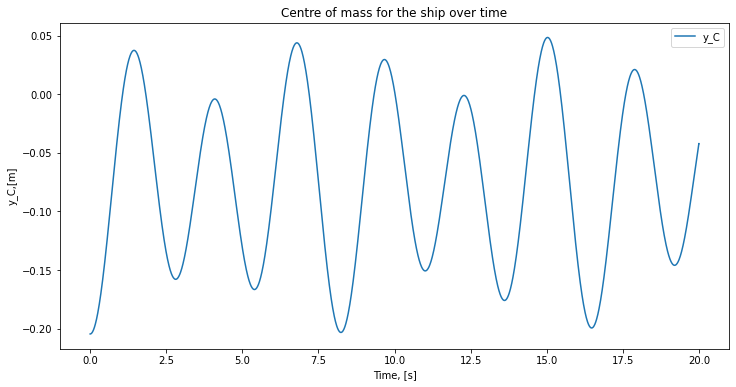

In [ ]:

fig, axs = plt.subplots(1,1)
axs.plot(t_ship_rk4,w_ship_rk4.T[3],label = "y_C")
axs.set_title("Centre of mass for the ship over time")
axs.set_xlabel("Time, [s]")
axs.set_ylabel("y_C,[m]")

plt.legend()
plt.show()

When the amount of displaced water changes, the buoyant torque and therefore the movement of the center of mass changes. This causes the ship to bob up and down in the water in addition to rotating. This is reflected in the plot above where we see the amplitude of the oscillations are varying over time. 

In [ ]:

init_ship2 = np.array([0,np.radians(15),0,centermass_0(sector_angle_0),0,0])
init_ship3 = np.array([0,np.radians(24),0,centermass_0(sector_angle_0),0,0])
init_ship4 = np.array([0,np.radians(24.73),0,centermass_0(sector_angle_0),0,0])
init_ship5 = np.array([0,np.radians(30),0,centermass_0(sector_angle_0),0,0])

t_ship_rk4, w_ship_rk4_2 = ode_solver(ship,0,20,init_ship2,0.01,method=runge_kutta_4)
t_ship_rk4, w_ship_rk4_3 = ode_solver(ship,0,20,init_ship3,0.01,method=runge_kutta_4)
t_ship_rk4, w_ship_rk4_4 = ode_solver(ship,0,20,init_ship4,0.01,method=runge_kutta_4)
t_ship_rk4, w_ship_rk4_5 = ode_solver(ship,0,20,init_ship5,0.01,method=runge_kutta_4)

In [ ]:
def capsize_array(w):
    array = np.zeros(w.shape[0])
    for i in range(w.shape[0]):
        array[i] = (np.pi-sector_angle(w[i]))/2
    return array
cap5 = capsize_array(w_ship_rk4_5)
cap2 = capsize_array(w_ship_rk4_2)
cap3 = capsize_array(w_ship_rk4_3)
cap4 = capsize_array(w_ship_rk4_4)
angle2 = np.radians(15) 
angle3 = np.radians(24)
angle4 = np.radians(24.73)
angle5 = np.radians(30)
print(angle2)
print(angle3)
print(angle4)
print(angle5)


0.2617993877991494
0.4188790204786391
0.4316199240181977
0.5235987755982988


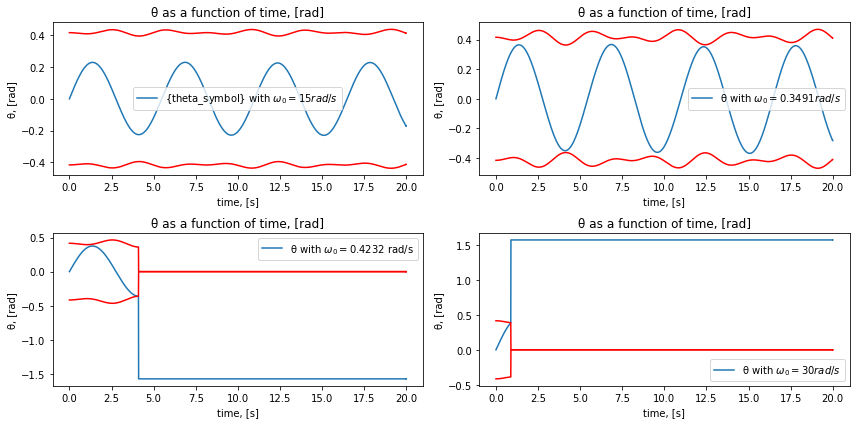

In [ ]:
fig, axs = plt.subplots(2,2)
plt.rcParams["figure.figsize"] = (12,6)
axs[0,0].plot(t_ship_rk4,w_ship_rk4_2.T[0], label = "{theta_symbol} with $\omega_0 = 15 rad/s$")
axs[0,0].set_title(f"{theta_symbol} as a function of time, [rad]")
axs[0,0].set_xlabel("time, [s]")
axs[0,0].plot(t_ship_rk4,cap2,'r')
axs[0,0].plot(t_ship_rk4,-cap2,'r')
axs[0,0].set_ylabel(f"{theta_symbol}, [rad]")
axs[0,0].legend()


axs[0,1].plot(t_ship_rk4,w_ship_rk4_3.T[0], label = f"{theta_symbol} with $\omega_0 = 0.3491 rad/s$" )
axs[0,1].set_title(f"{theta_symbol} as a function of time, [rad]")
axs[0,1].set_xlabel("time, [s]")
axs[0,1].set_ylabel(f"{theta_symbol}, [rad]")
axs[0,1].plot(t_ship_rk4,-cap3,'r')
axs[0,1].plot(t_ship_rk4,cap3,'r')
axs[0,1].legend()


axs[1,0].plot(t_ship_rk4,w_ship_rk4_4.T[0], label = f"{theta_symbol} with $\omega_0 = 0.4232$ rad/s")
axs[1,0].set_title(f"{theta_symbol} as a function of time, [rad]")
axs[1,0].set_xlabel("time, [s]")
axs[1,0].set_ylabel(f"{theta_symbol}, [rad]")
axs[1,0].plot(t_ship_rk4,-cap4,'r')
axs[1,0].plot(t_ship_rk4,cap4,'r')
axs[1,0].legend()


axs[1,1].plot(t_ship_rk4,w_ship_rk4_5.T[0],label = f"{theta_symbol} with $\omega_0 = 30 rad/s$")
axs[1,1].set_title(f"{theta_symbol} as a function of time, [rad]")
axs[1,1].set_ylabel(f"{theta_symbol}, [rad]")
axs[1,1].plot(t_ship_rk4,-cap5,'r')
axs[1,1].plot(t_ship_rk4,cap5,'r')
axs[1,1].set_xlabel("time, [s]")

axs[1,1].legend()
plt.tight_layout()
plt.show()



The plots above show how the angle $\theta$ behaves over time for different starting values for the angular velocity $\omega$. The values are
$$\omega_0 = 15\degree/s \approx 0.262 rad/s$$

$$\omega_0 = 24 \degree/s \approx 0.419 rad/s$$ 

$$\omega_0 = 24.73 \degree/s \approx 0.432 rad/s$$

$$\omega_0 = 30\degree/s \approx  0.524 rad/s$$. 

The smallest initial value for the angular velocity, $\omega$ that makes the boat capsize up to 3-decimal precision is $0.432$ radians per second. The red graphs illustrate the capsize condition at a given angle $\theta$ if the blue graph intersects the red graph the ship capsizes. The blue graphs are set to $\theta = \frac{\pi}{2}$ on the side the ship capsized on, the red graphs are set to $\theta = 0$. 
If the initial condition is much greater, like $0.524$ radians per second. the ship capsizes immediately, for values below $0.432$ radians per second the ship comes close to capsizing, but stays afloat unlike Vasa that faithfull day in 1628. This is best visualised by the graph with $$\omega_0 = 24 \degree/s \approx 0.419 rad/s$$ where we can clearlsy see the graphs almost touching, but not intersecting. This happens because the torque is able to counteract the rotation and stop the ship from hitting the capsize condition just in time before it sinks.



# Cargo ship

Like all ships the Vasa ship had cargo on board. Until now all the ships cargo ha been accounted for in the density, and in our model, been stored under deck. We are now going to look at the ship's dynamic with cargo on deck. In our model the cargo is a frictionless point mass sliding on the floor of the deck. In reality the cargo could have been a barrell, loose cannon or a crate of some sort. 

Once again we expand $\vec{w}$ to now include the position of the cargo and the corresponding velocity:

$$\vec{w} = \begin{bmatrix} \theta \\ \omega \\ x_C \\ y_C \\ v_x \\ v_y \\ s_L \\ v_L \end{bmatrix}$$

Now $\vec f (t,\vec w)$ will also output the velocity of the cargo $v_L$ and its acceleration $a_L$

$$\vec{f} (t,\vec{w}) = \frac{d\vec{w}}{dt} = \begin{bmatrix} \dot{\theta} \\ \dot{\omega} \\ v_x \\ v_y \\ a_x \\ a_y \\ v_L \\ a_L \end{bmatrix}$$

Just like last time we can find the forces and torques acting on the ship to calculate the directional accelerations and angular acceleration.

$$ \sum \tau = \tau_B  + \tau_L = -F_Bh\sin{\theta} - m_Lg\cos{\theta}s_L$$

$$ \sum F_y = F_G + F_B  + F_L^y = -mg + A\sigma_0 g -m_Lg\cos^2{\theta}$$

$$ \sum F_x = F_L^x = m_Lg\cos{\theta}\sin{\theta}$$

We also need to look at the forces acting on the cargo, so we can calculate $a_L$. Since we assumed a frictionless deck, the only forces would be the gravitational force, and the normal force from the ship. The cargo will never leave the deck vertically, so the normal force is then cancelled out by the gravitational component. The only force we're left with is the gravitational component in the $y$-direction, which is given by:

$$ a_L = -g\sin{\theta} $$

If the cargo falls of the ship, that is to say $|s_L| > R$ we will for now just make the cargo massless. For everything to work we also have to redefine the density of the ship. This is because the total mass will affect the sector angle and center of mass at equilibrium. We calculate the new density as followed:

$$ \sigma = \frac{m+m_L}{A_s} $$

Here $A_s$ is the ship area which is just the area of a half circle. 

This new mass will also change the inertia but with an inertia varying with time this problem will become way too complicated, therefore we overlook this fact.

In [ ]:
cargomass = lambda mass : 0.001*mass
total_mass = cargomass(shipmass) + shipmass # The total mass now includes the cargo
total_density = total_mass / (0.5 * np.pi * radius ** 2) # The new total density is what is used in other equations
sector_angle_0 = fixedpoint(groot,0) # Since the total mass is bigger the sector angle will also be bigger

torque = lambda w, cargo : (-buoyancy(water_area(w))*h*np.sin(w[0]) - cargo*g*np.cos(w[0])*np.abs(w[6])) # Sum of torques
force_x = lambda w, cargo : cargo*g*np.cos(w[0])*np.sin(w[0]) # Sum of forces in x direction
force_y = lambda w, cargo : (-total_mass*g+buoyancy(water_area(w))-cargo*g*np.cos(w[0])**2) # Sum of forces in y direction

def cargoship(t, w):
    """
    t: Function variable.
    w: w-vector.

    This is a modelling of the ship with cargo, with torque and forces in x- and y-direction.

    Return: The elements of the f-function output.
    """
    cargo = cargomass(shipmass) if (w[6] < radius) else cargomass(0) # If the cargo falls off we set its mass to 0
    return np.array([w[1],torque(w,cargo)/inertia,w[4],w[5],force_x(w,cargo)/total_mass,force_y(w,cargo)/total_mass,w[7],-g*np.sin(w[0])])

In [ ]:
cargomass = lambda mass : 0.001*mass
total_mass = cargomass(shipmass) + shipmass # The total mass now includes the cargo
total_density = total_mass / (0.5 * np.pi * radius ** 2) # The new total density is what is used in other equations
sector_angle_0 = fixedpoint(groot,0)
init_cargoship = np.array([np.radians(0),0.2,0,centermass_0(sector_angle_0),0,0,3,0])
t_cargo, w_cargo = ode_solver(cargoship,0,40,init_cargoship,0.01,method=runge_kutta_4)


cargomass = lambda mass : 0.08*mass
total_mass = cargomass(shipmass) + shipmass
total_density = total_mass / (0.5 * np.pi * radius ** 2)
sector_angle_0 = fixedpoint(groot,0)
init_cargoship2 = np.array([np.radians(0),0.2,0,centermass_0(sector_angle_0),0,0,3,0])
t_cargo2, w_cargo2 = ode_solver(cargoship,0,40,init_cargoship2,0.01,method=runge_kutta_4)

In [ ]:
fallen_off = np.argwhere(np.abs(w_cargo.T[6]) >= radius) #Gives the index where the light mass falls off
fallen_off2 = np.argwhere(np.abs(w_cargo2.T[6]) > radius) #Gives the index where the light mass falls off


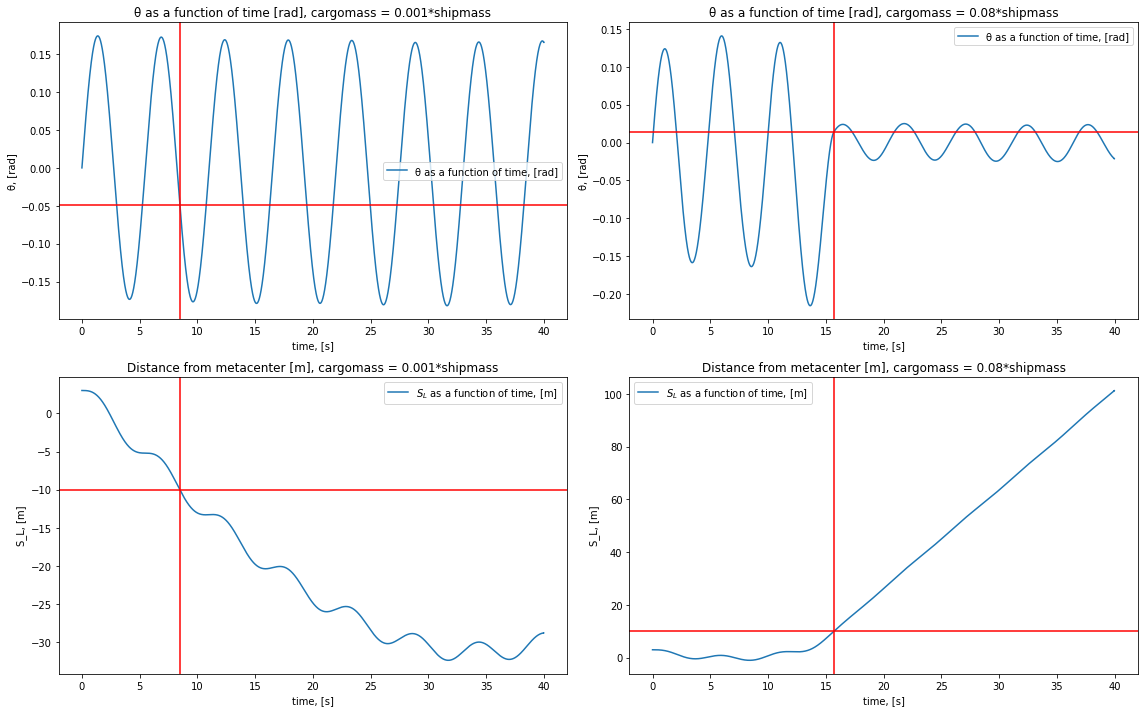

In [ ]:
plt.rcParams["figure.figsize"] = (16,10)
fig, axs = plt.subplots(2,2)
axs[0,0].plot(t_cargo,w_cargo.T[0], label = f"{theta_symbol} as a function of time, [rad]")
axs[0,0].set_title(f"{theta_symbol} as a function of time [rad], cargomass = 0.001*shipmass")
axs[0,0].set_xlabel("time, [s]")
axs[0,0].set_ylabel(f"{theta_symbol}, [rad]")
axs[0,0].axhline(w_cargo.T[0][fallen_off[0]], color = 'r', linestyle = '-')
axs[0,0].axvline(t_cargo2[fallen_off[0]], color = 'r',linestyle = '-')
axs[0,0].legend()

axs[0,1].plot(t_cargo2,w_cargo2.T[0],label = f"{theta_symbol} as a function of time, [rad]")
axs[0,1].set_title(f"{theta_symbol} as a function of time [rad], cargomass = 0.08*shipmass")
axs[0,1].set_xlabel("time, [s]")
axs[0,1].set_ylabel(f"{theta_symbol}, [rad]")
axs[0,1].axhline(w_cargo2.T[0][fallen_off2[0]], color = 'r', linestyle = '-')
axs[0,1].axvline(t_cargo[fallen_off2[0]], color = 'r', linestyle = '-')
axs[0,1].legend()

axs[1,0].plot(t_cargo2,w_cargo.T[6],label = "$S_L$ as a function of time, [m]")
axs[1,0].set_title(f"Distance from metacenter [m], cargomass = 0.001*shipmass")
axs[1,0].set_xlabel("time, [s]")
axs[1,0].set_ylabel(f"S_L, [m]")
axs[1,0].axhline(-radius, color = 'r', linestyle = '-')
axs[1,0].axvline(t_cargo2[fallen_off[0]], color = 'r',linestyle = '-')
axs[1,0].legend()

axs[1,1].plot(t_cargo2,w_cargo2.T[6],label = "$S_L$ as a function of time, [m]")
axs[1,1].set_title(f"Distance from metacenter [m], cargomass = 0.08*shipmass")
axs[1,1].set_xlabel("time, [s]")
axs[1,1].set_ylabel(f"S_L, [m]")
axs[1,1].axhline(radius, color = 'r', linestyle = '-')
axs[1,1].axvline(t_cargo2[fallen_off2[0]], color = 'r',linestyle = '-')
axs[1,1].legend()




plt.tight_layout()
plt.show()




In the above plots we have modelled the movement of cargo with two different masses. The first two plots shows how $\theta$ is affected by the moving point mass. The bottom two plots shows the position of the point mass over time. The red cross in each plot marks the point where the cargo falls off the ship. The torque from the small cargo contributes almost nothing to the total torque of the system, this is reflected by the fact that the amplitude of $\theta$ is the same before and after the cargo falls into the ocean. It also falls off rather quickly. 

The heavy cargo is much more impactfull and we can see that the rotation angle's amplitude decreases after the cargo falls off the ship. After it has fallen off the ship starts oscillating around a new equilibrium. This is because the heavy cargo is actually heavy enough to contribute an impactfull torque to the ship. This means that if the cargo falls of on the side that is moving in the positive y-direction the amplitude will decrease. The opposite happens if it falls off on the side that is on the way down in negative y-direction. In our plot the first of the two is what is happening. 





Most normal boats don't let their cargo fall off the ship, so from now, we are going to start simulating that the ship has fences on each side of the deck. Mathematically we can do this by restricting the $s_L$ value to only appear in $|s_L|<R$ and reducing the cargo speed to $0$ when it is on the edge.

In [ ]:
def fenced_ship(t, w):
    """
    t: Function variable.
    w: w-vector.

    This is a modelling of the ship with cargo, with torque and forces in x- and y-direction. The ship has fences so the cargo
    won't fall off.

    Return: The elements of the f-function output.
    """
    cargo = cargomass(shipmass)
    if (np.abs(w[6]) > radius):
        w[6] = np.sign(w[6])*radius # We need to keep the cargo on deck
        w[7] = 0 # The speed is reduced to 0 to prevent it from sliding through the "fence"
    return np.array([w[1],torque(w,cargo)/inertia,w[4],w[5],force_x(w,cargo)/total_mass,force_y(w,cargo)/total_mass,w[7],-g*np.sin(w[0])])

In [ ]:
cargomass = lambda mass : 0.001*mass
total_mass = cargomass(shipmass) + shipmass
total_density = total_mass / (0.5 * np.pi * radius ** 2)
sector_angle_0 = fixedpoint(groot,0)
init_fenced_ship = np.array([np.radians(0),0.2,0,centermass_0(sector_angle_0),0,0,3,0])
t_fenced, w_fenced_1 = ode_solver(fenced_ship,0,40,init_fenced_ship,0.01,method=runge_kutta_4)

cargomass = lambda mass : 0.08*mass
total_mass = cargomass(shipmass) + shipmass
total_density = total_mass / (0.5 * np.pi * radius ** 2)
sector_angle_0 = fixedpoint(groot,0)
init_fenced_ship2 = np.array([np.radians(0),0.2,0,centermass_0(sector_angle_0),0,0,3,0])
t_fenced, w_fenced_2 = ode_solver(fenced_ship,0,40,init_fenced_ship2,0.01,method=runge_kutta_4)


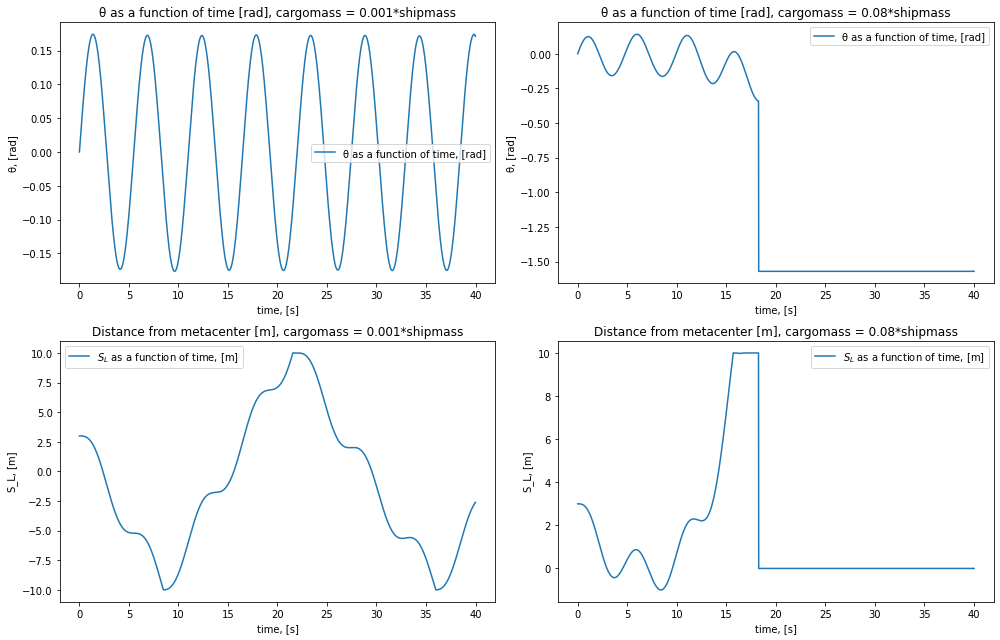

In [ ]:
plt.rcParams["figure.figsize"] = (14,9)
fig, axs = plt.subplots(2,2)
axs[0,0].plot(t_cargo,w_fenced_1.T[0], label = f"{theta_symbol} as a function of time, [rad]")
axs[0,0].set_title(f"{theta_symbol} as a function of time [rad], cargomass = 0.001*shipmass")
axs[0,0].set_xlabel("time, [s]")
axs[0,0].set_ylabel(f"{theta_symbol}, [rad]")
axs[0,0].legend()

axs[0,1].plot(t_cargo2,w_fenced_2.T[0],label = f"{theta_symbol} as a function of time, [rad]")
axs[0,1].set_title(f"{theta_symbol} as a function of time [rad], cargomass = 0.08*shipmass")
axs[0,1].set_xlabel("time, [s]")
axs[0,1].set_ylabel(f"{theta_symbol}, [rad]")
axs[0,1].legend()

axs[1,0].plot(t_cargo2,w_fenced_1.T[6],label = "$S_L$ as a function of time, [m]")
axs[1,0].set_title(f"Distance from metacenter [m], cargomass = 0.001*shipmass")
axs[1,0].set_xlabel("time, [s]")
axs[1,0].set_ylabel(f"S_L, [m]")
axs[1,0].legend()

axs[1,1].plot(t_cargo2,w_fenced_2.T[6],label = "$S_L$ as a function of time, [m]")
axs[1,1].set_title(f"Distance from metacenter [m], cargomass = 0.08*shipmass")
axs[1,1].set_xlabel("time, [s]")
axs[1,1].set_ylabel(f"S_L, [m]")
axs[1,1].legend()




plt.tight_layout()
plt.show()

Ship dynamic with light cargo.

These plots have the same layout as the plots for the cargo ship without fences discussed previously. When fences are introduced the light mass stays on the ship for the entirity of the time interval. Looking at the path of the cargo we can deduce what way the ship is rotating. When the cargo is moving towards the left side of the ship, downwards on the graph of its path, a rotation with a positive value for $\theta$ will slow down the cargo. A negative rotation will speed it up. For movement to the right side of the ship the changes in velocity is affected in the opposite way. 

Ship dynamic with heavy cargo. 

The rotation angle starts oscillating, but as soon as the cargo moves to either side of the ship the rotation angle starts oscillating around larger and larger values for $\theta$ before the cargo speeds up, hits the fence and capsizes the ship. Visually this is best represented by the speed at which the cargo moves along its path towards the fence. When the cargo reaches the fence, there is not enough buoyant torque to counteract the affect the cargo has on the ship and the ship sinks. 

We will now return to an earlier version of $\vec w$. At this point we will no longer study the ship with free moving cargo on deck, which leaves us with $ \vec w = \begin{bmatrix} \theta & \omega & x & y & v_x & v_y \end{bmatrix}^T $. The point of this is to explore the impact of other forces such as water friction or waves or wind. We have until now assumed that the water in contact with the ship hull is frictionless, while in reality this is obviously not true. We define the friction force as following:

$$ f = -k_fR\gamma \omega $$

Here the friction coefficient $k_f$ is just an arbitrary number with units $\textrm{kg/s}$ in our case, since the fluid dynamics in this problem would be complicated. We will also include a force simulating wind and waves. We will just use one simple harmonic horizontal force for both wind and waves $F_w (t) $.

$$ F_w (t) = F_0 \cos{\omega_w t} $$

Here $F_0$ is the amplitude of the harmonic force and $\omega_w$ is the frequency.

Since we have new forces in play we will have to calculate the sum of the forces and torque once again to continue our numerical adventure.

$$ \sum \tau = \tau_B  + \tau_f + \tau_w = -F_Bh\sin{\theta} + f\left(y_C-R\left(\cos{\frac{\gamma}{2}}-1\right)\right) + F_wy_C$$

$$ \sum F_y = F_G + F_B = -mg + A\sigma_0 g $$

$$ \sum F_x = F_w - f = F_0\cos{\omega_w t} - (- k_f R \gamma \omega)$$

In [ ]:
cargomass = lambda mass : 0*mass
total_mass = shipmass # The total mass now includes the cargo
total_density = total_mass / (0.5 * np.pi * radius ** 2) # The new total density is what is used in other equations
sector_angle_0 = fixedpoint(groot,0)
friction_coeff = 100
amplitude = 0*shipmass
wavewind_freq = 0.93*np.sqrt(shipmass*g*h/inertia)
total_mass = shipmass


friction = lambda w : -friction_coeff*radius*sector_angle(w)*w[1]
wavewind = lambda w,t : amplitude*np.cos(wavewind_freq*t)

# The forces in x- and y-direction and torque
torque = lambda w, t : (-buoyancy(water_area(w))*h*np.sin(w[0]) + friction(w)*(centermass_0(sector_angle_0)-radius*(np.cos(sector_angle(w)/2)-1)) + wavewind(w,t)*centermass_0(sector_angle_0))
force_x = lambda w, t : (-friction(w) + wavewind(w,t))
force_y = lambda w, t : buoyancy(water_area(w)) - g*total_mass

In [ ]:
def sailship(t,w):
    """
    t: Function variable.
    w: w-vector.

    This is a modelling of the ship with with water friction and wind/waves as a harmonic force, with torque and 
    forces in x- and y-direction.

    Return: The elements of the f-function output.
    """
    return np.array([w[1],torque(w,t)/inertia,w[4],w[5],force_x(w,t)/total_mass,force_y(w,t)/total_mass])

In [ ]:
init_sailship = np.array([np.radians(0),0.4,0,centermass_0(sector_angle_0),0,0])

friction_coeff = 100
t_sail, w_sail = ode_solver(sailship,0,40,init_sailship,0.01,method=runge_kutta_4)
friction_coeff = 1000
t_sail, w_sail_2 = ode_solver(sailship,0,40,init_sailship,0.01,method=runge_kutta_4)
friction_coeff = 10000
t_sail, w_sail_3 = ode_solver(sailship,0,40,init_sailship,0.01,method=runge_kutta_4)


# Ship dynamic analysis for varying friction coefficients

In this section we will look at three different parameters for the ship dynamic. The variables we will take a closer look at is, the angle $\theta$, the movement of $y_C$, the movement of the centre of mass in x direction. 

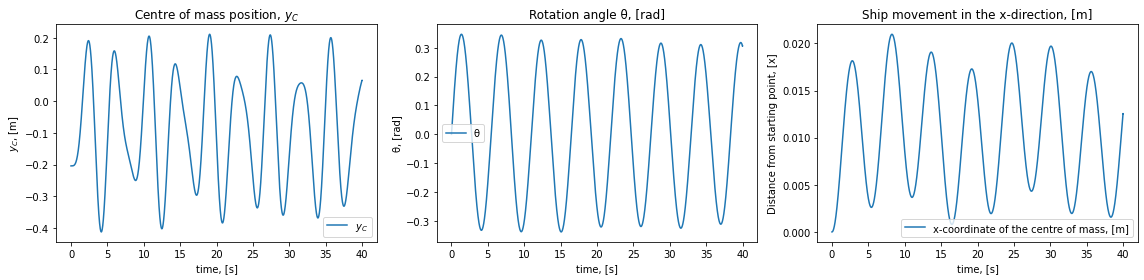

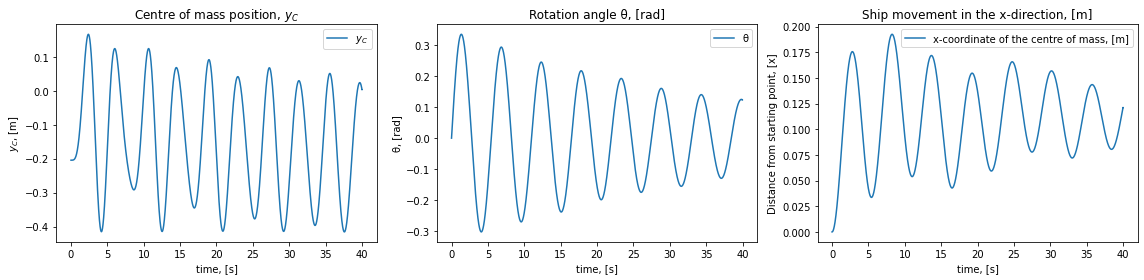

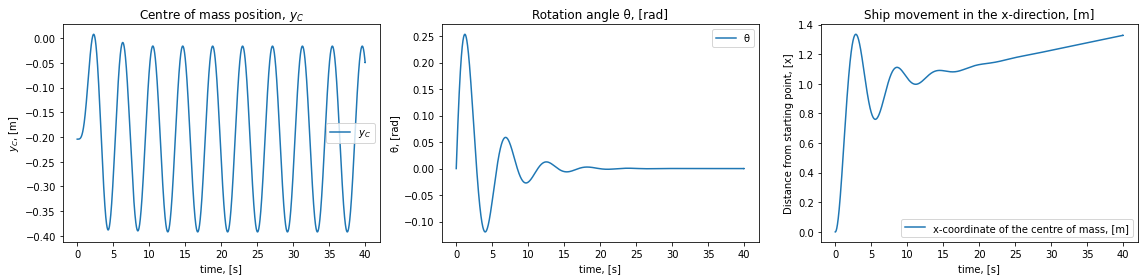

In [ ]:
#Plotting code block, using three subplots to get the right proportions
fig, axs = plt.subplots(1,3)
axs[0].plot(t_sail,w_sail.T[3], label = "$y_C$")
axs[0].set_ylabel("$y_C$, [m]")
axs[0].set_title("Centre of mass position, $y_C$")
axs[0].set_xlabel("time, [s]")
axs[0].legend()

axs[1].plot(t_sail,w_sail.T[0],label = f"{theta_symbol}")
axs[1].set_xlabel("time, [s]")
axs[1].set_ylabel(f"{theta_symbol}, [rad]")
axs[1].set_title(f"Rotation angle {theta_symbol}, [rad]")
axs[1].legend()

axs[2].plot(t_sail,w_sail.T[2],label = "x-coordinate of the centre of mass, [m]")
axs[2].set_ylabel("Distance from starting point, [x]")
axs[2].set_xlabel("time, [s]")
axs[2].set_title("Ship movement in the x-direction, [m]")
axs[2].legend()

plt.tight_layout()

plt.show()
fig, axs = plt.subplots(1,3)
axs[0].plot(t_sail,w_sail_2.T[3],  label = "$y_C$")
axs[0].set_ylabel("$y_C$, [m]")
axs[0].set_xlabel("time, [s]")
axs[0].set_title("Centre of mass position, $y_C$")
axs[0].legend()

axs[1].plot(t_sail,w_sail_2.T[0],label = f"{theta_symbol}")
axs[1].set_xlabel("time, [s]")
axs[1].set_ylabel(f"{theta_symbol}, [rad]")
axs[1].set_title(f"Rotation angle {theta_symbol}, [rad]")
axs[1].legend()

axs[2].plot(t_sail,w_sail_2.T[2],label = "x-coordinate of the centre of mass, [m]")
axs[2].set_ylabel("Distance from starting point, [x]")
axs[2].set_xlabel("time, [s]")
axs[2].set_title("Ship movement in the x-direction, [m]")
axs[2].legend()

plt.tight_layout()

plt.show()


fig, axs = plt.subplots(1,3)
axs[0].plot(t_sail,w_sail_3.T[3], label = "$y_C$")
axs[0].set_xlabel("time, [s]")
axs[0].set_ylabel("$y_C$, [m]")
axs[0].set_title("Centre of mass position, $y_C$")
axs[0].legend()

axs[1].plot(t_sail,w_sail_3.T[0],label = f"{theta_symbol}")
axs[1].set_xlabel("time, [s]")
axs[1].set_ylabel(f"{theta_symbol}, [rad]")
axs[1].set_title(f"Rotation angle {theta_symbol}, [rad]")
axs[1].legend()

axs[2].plot(t_sail,w_sail_3.T[2],label = "x-coordinate of the centre of mass, [m]")
axs[2].set_xlabel("time, [s]")
axs[2].set_ylabel("Distance from starting point, [x]")
axs[2].set_title(f"Ship movement in the x-direction, [m]")
axs[2].legend()

plt.tight_layout()
plt.show()

In the above plots the coefficient of friction $k_f$ is given three different orders of magnitude namely $10^2$, $10^3$ and $10^4$. The first three plots uses $k_f = 10^2$. The angle of the rotation $\theta$ is ever so slightly dampened, but since the coefficient of friction is relatviely small this is not noticeable for an interval of $40$ seconds. As the coefficient increases the rotation is dampened more and more, and for large coefficients the oscillating rotation is brought to a complete stop. Instead the ship oscillates up and down in the water, and floats off to the right side.

In [ ]:
cargomass = lambda mass : 0*mass
total_mass = shipmass # The total mass now includes the cargo
total_density = boat_density # The new total density is what is used in other equations
friction_coeff = 100
amplitude = 0.625*shipmass*g
wavewind_freq_0 = np.sqrt(shipmass*g*h/inertia)
wavewind_freq = 0.925*wavewind_freq_0
sector_angle_0 = fixedpoint(groot,0)


init_sailship2 = np.array([np.radians(0),np.radians(2),0,centermass_0(sector_angle_0),0,0])
t_sail_g, w_sail_g = ode_solver(sailship,0,240,init_sailship2,0.01,method=runge_kutta_4)



To really study the effect of the harmonic friction force, we set the following parameters:

$$ k_f = 100$$

$$ \theta(t=0)=0$$

$$\omega(t=0) = 2\degree/s $$

$$ \omega_\omega = 0.925\omega_0$$

$$ F_0 = 0.625mg$$


Modelling over a longer time intervall gives us the opportunity to really study how the harmonic friction force affects the ship dynamic. We are supposed to use $$ \omega_\omega = 0.93\omega_0$$ However if we use that value our ship capsizes, this is most likely caused by a global variable having a value it’s not supposed to have, and therefore interfering with the calculations. As a result we have chosen to use the value $0.925$ as this gives us the beat pattern we are supposed to get because it keeps the frequency of the harmonic force within a reasonable length of the frequency of the angle oscillations. And lets us study the system over time.

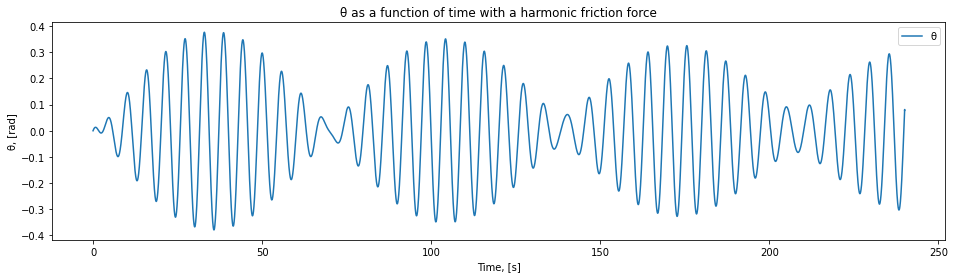

In [ ]:
plt.plot(t_sail_g,w_sail_g.T[0],label = f"{theta_symbol}")
plt.title(f"{theta_symbol} as a function of time with a harmonic friction force")
plt.xlabel("Time, [s]")
plt.ylabel(f"{theta_symbol}, [rad]")
plt.legend()
plt.show()

In the plot above we have modelled how the ship behaves when an external harmonic friction force affects the ship. The beat pattern we get is because the frequency of the angle oscillation and the harmonic force is almost identical. 

In [ ]:
def bogshamp(t,w,f,step,k1):
    k2 = f(t+0.5*step, w+0.5*step*k1)
    k3 = f(t+0.75*step,w+step*0.75*k2)
    w_next = w + (2/9)*step*k1 + (1/3)*step*k2 + (4/9)*step*k3
    k4 = f(t+step,w_next)
    z_next = w + (7/24)*step*k1 + 0.25*step*k2 + (1/3)*step*k3 + (1/8)*k4*step
    t_next = t + step
    error_estimate = np.linalg.norm(w_next-z_next)
    p = 2
    return t_next, w_next, error_estimate, p, k4

# Bogacki-Shampine vs Runge Kutta4

In this section we will use Bogacki-shampine and RK4 to find the eigenfrequencies relative to the analytic eigenfrequency. We expect the relative eigenfrequency to be close to the analytic eigenfrequency. 

The reason behind choosing Bogacki-Shampine as our ODE-solver is because it utilizes first same as last, is a runge-kutta of order 3 and it has an embedded method of order two. This lets us calculate an error estimate and we can therefore use an adaptive step length. The first same as last property means that the last step $k_4$ equals the $k_1$ in the next step. You therefore only have to calculate 3 function evaluations at each step. 

We let the coefficient of friction be $0$, and search for the eigenfrequencies around the analytic eigenfrequency. 

In [ ]:
def ode_adaptive(f, t_0, t_end, w_0, step_0, tol = 1.e-6, method=bogshamp):
    '''
    
    f: Input function.
    t_0: The starting point of the dependant variable.
    t_end: The end point of the dependant variable.
    w_0: Initial conditions of the function.
    step_0: Size of the first step.
    method: What iteration method is to be used.
    tol: default value 1.e-6

    The function that adaptively solves the differential equation nummericaly.

    Return: Arrays with the w-vector- and t-values
    

    '''
    w_num = np.array([w_0])
    t_num = np.array([t_0])

    tn = t_0
    wn = w_0 
    step = step_0
    ncall = 0
    
    kn = f(t_0,w_0)
    while tn < t_end - 1.e-10:
        if tn + step > t_end:                   
            step = t_end - tn 
        
        t_try, w_try, error_estimate, p, kn_try = method(tn,wn,f,step,kn)
        ncall = ncall + 1
        
        if error_estimate <= tol:   
            tn = t_try    
            wn = w_try
            kn = kn_try
            w_num = np.concatenate((w_num, np.array([wn])))
            t_num = np.append(t_num, tn)
        
        step = 0.9*(tol/error_estimate)**(1/(p+1))*step
        
        if ncall > 100000:
            return t_num, w_num
    return t_num, w_num

In [ ]:
frequencies = np.linspace(wavewind_freq_0-0.1,wavewind_freq_0+0.1,100)
amplitude = 0.625*shipmass*g
friction_coeff = 0
total_mass = shipmass
total_density = boat_density
sector_angle_0 = fixedpoint(groot,0)
eigenfrequency_rk = 0
eigenfrequency_bs = 0

low_cap_rk = 0
low_cap_bs = 0

for frequency in frequencies:

    wavewind_freq = frequency
    init = np.array([np.radians(0),np.radians(0),0,centermass_0(sector_angle_0),0,0])

    tn_rk, wn_rk = ode_solver(sailship,0,20,init,0.01)
    tn_bs, wn_bs = ode_adaptive(sailship,0,20,init,0.01)

    capped_rk = np.argwhere(np.abs(wn_rk.T[0]) >= np.abs(np.pi/2))
    prev_cap_rk = np.shape(wn_rk.T[0])[0] + 1

    capped_bs = np.argwhere(np.abs(wn_bs.T[0]) >= np.abs(np.pi/2))
    prev_cap_bs = np.shape(wn_bs.T[0])[0] + 1

    if capped_rk.shape[0] > 0:
        low_cap_rk = capped_rk[0]

    if capped_bs.shape[0] > 0:
        low_cap_bs = capped_bs[0]

    if low_cap_rk < prev_cap_rk:
        prev_cap_rk = low_cap_rk
        eigenfrequency_rk = frequency
    
    if low_cap_bs < prev_cap_bs:
        prev_cap_bs = low_cap_bs
        eigenfrequency_bs = frequency


In [ ]:
print(f'This is the relative eigenfrequency we found using RK4: {eigenfrequency_rk/wavewind_freq_0}')
print(f'This is the relative eigenfrequency we found using Bogacki-Shampine: {eigenfrequency_bs/wavewind_freq_0}')

This is the relative eigenfrequency we found using RK4: 1.087651663436226
This is the relative eigenfrequency we found using Bogacki-Shampine: 1.087651663436226


The values printed above are the values we found for the relative eigenfrequency using the two different methods. These frequencies will make the ship capsize even though the angular start velocity is very small. There is no difference in values produced by the two methods and it is hard to determine which is better than the other. 

Our model of the ship is very simple, but it gives us enough insight to draw conclusions on what happened to the Vasa ship on its maiden voyage. One of the main problems for the Vasa ship was stability and that the center of gravity was located above water. There were other factors that played a role in the sinking of the Vasa, such as cargo, wind, and friction from the water. We have successfully studied the role of some of these factors in the stability of a ship. In our numerical adventure the main reasons for our ship capsizing has been the magnitude of the starting angle $\theta_0$ and starting angular velocity $\omega_0$. What would have been more interesting to study is how the water started to flow into the first cannon deck when the boat started sinking. Fluid mechanics is notoriously hard to model, the capsizing of the ship with cargo is therefore a good analogy of the effect taking in water has on the dynamics of the ship. We observed that when the heavier of the two masses slid over to one of the sides, the boat quickly careens and eventually capsizes, as if water has started flowing inside the ship. 

The other part of this project has been comparing different ODE solvers. As aforementioned in the first part of the project, RK4 is a stronger, and better ODE solver than Euler’s method. When we compare the two solvers over different step sizes, RK4 consistently performs with a smaller margin of error. The order of each solver is also easily confirmed through a plot with logarithmic scales. It is hard to tell if RK4 or Bogacki-shampine is better based purely on the calculations we have performed. However an adaptive solver has the possibility to adjust its accuracy on intervals that require short step sizes to compute accurate results. This combined with the fact that you use first same as last to reduce the number of function evaluation at each step makes Bogacki-Shampine a very strong tool for solving ODEs numerically


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dd69b193-1ef7-41e2-aebb-01ee0d367201' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>